In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import keras as kr
print(kr.__version__)


2.11.0





<center>
<h1>Deep Learning with Python</h1>
<h2>Name Entity Recognition</h2>
<h3>Andrea Ferreira</h3>
<h3>Tutorial - 20/06/2024</h3>

</center>

This tutorial aims to present a real computational linguistics problem: solving a multiclass classification task to determine whether a given word is a Named Entity and identify its type.

The input consists of sentences extracted from the "Corpus for Named Entity Recognition" using the Groningen Meaning Bank corpus (University of Groningen, 2020). This corpus includes thousands of texts in both raw and tokenized formats, along with annotations for parts of speech, named entities, lexical categories, and other natural language structural phenomena. (more at [Groningen Meaning Bank](https://developer.ibm.com/exchanges/data/all/groningen-meaning-bank/)).

The dataset with 1M x 4 dimensions contains columns "Sentence, Word, POS, Tag", it is grouped by Sentence and available in [Kaggle](https://www.kaggle.com/datasets/namanj27/ner-dataset) (one token per line).

There are 17 labels for NER: **B-per, I-per, B-gpe, I-gpe, B-tim, I-tim, B-eve, I-eve, B-art, I-art, B-nat, I-nat, B-org, I-org, B-geo, I-geo and O (Outside tags)**.

>(**B**- stands for *"Beginning"* and **I**- stands for *"Inside"*)
>
>**Examples:** 
>
>for "Elton John"     
>**B-per** = Elton > **I-per** = John
>
>for "Sir Elton John"     
>**B-per** = Sir **I-per** = Elton > **I-per** = John



They represent 8 standard named entity recognition tags as follows:

**per = Person / gpe = Geopolitical Entity / tim = Time indicator** 
<br>
**eve = Event / art = Artifact / nat = Natural Phenomenon**
<br>
**org = Organization / geo = Geographical Entity**


The two steps we will perform are the following:

1. **Pre-processing data.**
2. **Create a multi-class classifier using Keras.**


## Importing the first libraries

In [3]:
import pandas as pd


## Data Checking and Preprocessing

In [4]:
# Reading data with pandas

data = pd.read_csv("/compLing/students/courses/deepLearning/tutorials/ner_data.csv", encoding = "ISO-8859-1")

# encoding = "ISO-8859-1" - to convert in ASCII (Latin alphabet) 


In [4]:
# Visualizing commonly used words in the dataset

# ! pip install wordcloud  


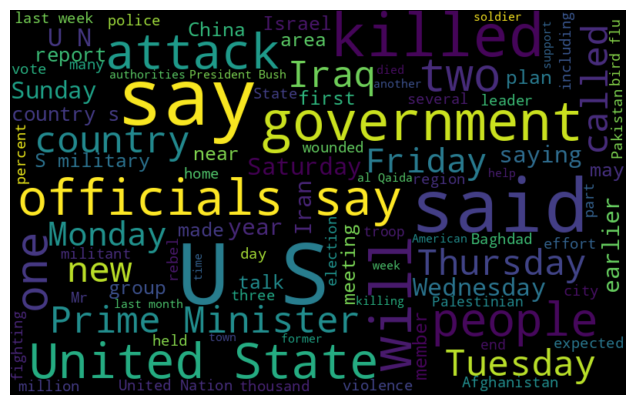

In [3]:
# Visualizing all words

import matplotlib.pyplot as plt  
from wordcloud import WordCloud

all_words = " ".join(data['Word'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=500,
                      background_color="black",
                      min_font_size=15, 
                      max_font_size=110,
                      random_state=21).generate(all_words)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()


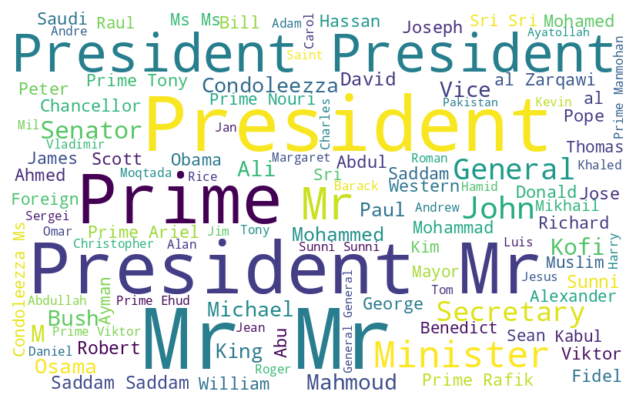

In [4]:
# Visualizing the tag "B-per" 

import matplotlib.pyplot as plt  
from wordcloud import WordCloud

tags_ner = " ".join([text for text in data["Word"][data["Tag"] == "B-per"]])
wordcloud = WordCloud(width=800, height=500,
                      background_color="white",
                      min_font_size=15, 
                      max_font_size=110,
                      random_state=21).generate(tags_ner)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()


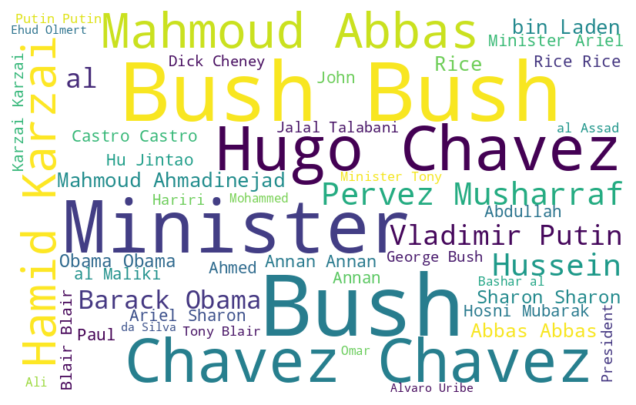

In [5]:
# Visualizing the tag "I-per" 

import matplotlib.pyplot as plt  
from wordcloud import WordCloud

tags_ner = " ".join([text for text in data["Word"][data["Tag"] == "I-per"]])
wordcloud = WordCloud(width=800, height=500,
                      background_color="white",
                      min_font_size=15, 
                      max_font_size=110,
                      random_state=21).generate(tags_ner)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()


In [20]:
# Checking data shape 

print(data)
data.shape


          Sentence #           Word  POS Tag
0        Sentence: 1      Thousands  NNS   O
1                NaN             of   IN   O
2                NaN  demonstrators  NNS   O
3                NaN           have  VBP   O
4                NaN        marched  VBN   O
...              ...            ...  ...  ..
1048570          NaN           they  PRP   O
1048571          NaN      responded  VBD   O
1048572          NaN             to   TO   O
1048573          NaN            the   DT   O
1048574          NaN         attack   NN   O

[1048575 rows x 4 columns]


(1048575, 4)

In [7]:
# Checking the Sentence: 1

data.head(25)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [8]:
# Checking the last sentence

data.tail(10)

# all those NaN are missing values (Not a Number)


,Sentence #,Word,POS,Tag
1048565,NaN,impact,NN,O
1048566,NaN,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,NaN,forces,NNS,O
1048569,NaN,said,VBD,O
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


In [11]:
# Checking data types 

data.dtypes

# the types can be numbers (float64, int32...), bool (T/F), string, etc.


Sentence #    object
Word          object
POS           object
Tag           object
dtype: object

In [21]:
# Checking for missing values 

data.isna()

# True = datapoints are missing

,Sentence #,Word,POS,Tag
0,False,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False
...,...,...,...,...
1048570,True,False,False,False
1048571,True,False,False,False
1048572,True,False,False,False
1048573,True,False,False,False


In [22]:
# Checking for missing values 

data.isna().sum()

# Total rows 1048575 - 47959 Sentences = 1000616 empty cells/datapoints are missing

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [5]:
# Imputing missing value 

data = data.ffill()

# 'ffill' to fill in the data with the value from the previous cell 'forward'
# 'bfill' to fill in the data with the vlaue from the next cell 'backward'


In [6]:
# Checking again

data.isna().sum()

# now here is not missing datapoints

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [6]:
# Checking how it is now

data[20:30]


,Sentence #,Word,POS,Tag
20,Sentence: 1,from,IN,O
21,Sentence: 1,that,DT,O
22,Sentence: 1,country,NN,O
23,Sentence: 1,.,.,O
24,Sentence: 2,Families,NNS,O
25,Sentence: 2,of,IN,O
26,Sentence: 2,soldiers,NNS,O
27,Sentence: 2,killed,VBN,O
28,Sentence: 2,in,IN,O
29,Sentence: 2,the,DT,O


In [26]:
# Checking how it is now

data.tail()

# 47959 Sentences

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [7]:
# Checking unique values in dataset 

print("Unique words in corpus:", data["Word"].nunique())
print("Unique tags in corpus:", data["Tag"].nunique())

print("We have 47959 sentences containing", data["Word"].nunique(), "different words.")

# nunique() counts number of distinct elements in specified axis
# but you can also use len()


Unique words in corpus: 35177
Unique tags in corpus: 17
We have 47959 sentences containing 35177 different words.


In [8]:
# Assigning a variable with the number of words from words list

words = list(set(data["Word"].values))
words.append("ENDPAD") # ENDPAD is add in the end of the list
num_words = len(words)

print("Number of unique words including 'ENDPAD':", num_words)

# the variable 'num_words' with the length of our vocabulary instead of 'len = 35178'


Number of unique words including 'ENDPAD': 35178


In [9]:
# Assigning a variable with the number of tags from tags list

tags = list(set(data["Tag"].values))
num_tags = len(tags)

print("Number of tags:", num_tags)

# the variable 'num_tags' will be used instead of 17


Number of tags: 17


In [10]:
# Retrieving sentences with their Word+POS+Tag
# Getting the sentences (grouping/aggregating) 

class SentenceGetter(object):
  def __init__(self, data):    # the method must have 2 underscores on each side
    self.num_sent = 1          # number of sentences
    self.data = data             # zip method returns a single iterator object, 
                                 # having mapped values from all the containers.
    agg_func = lambda s:[(w,p,t) for w, p, t in zip(s["Word"].values.tolist(),
                                                   s["POS"].values.tolist(),
                                                    s["Tag"].values.tolist())]
                     
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]  
    

In [11]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]    


[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

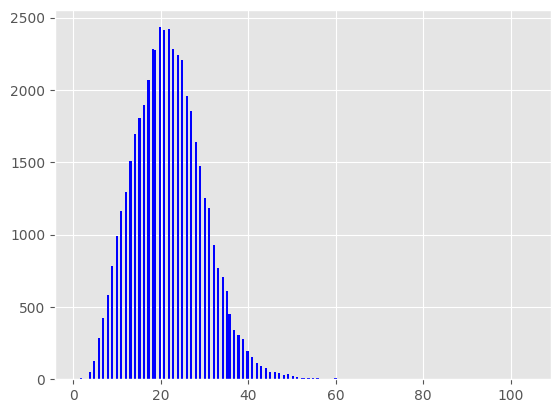

In [35]:
# Checking sentence length distribution

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], color = 'b', bins=200)
plt.show()


In [12]:
# For neural networks in Keras is recommended to use equal lenght input 
# sentences, that is why the max length of 50 for pad

max_len = 50  


In [13]:
# Mapping between sentences and tags to create dictionaries with indexes 

word_idx = {}
for i, w in enumerate(words):
    word_idx[w] = i + 1

tag_idx = {}
for i, t in enumerate(tags):
    tag_idx[t] = i

    
# optional shorter syntax:

# word_idx = {w: i+1 for i, w in enumerate(words)}
# tag_idx = {t: i for i, t in enumerate(tags)}  


In [1]:
# Words enumerated

print(word_idx)
print(word_idx.get("ENDPAD"))
print('The last word is:',words[-1])


In [15]:
# Tags enumerated

tag_idx


{'B-eve': 0,
 'I-gpe': 1,
 'B-geo': 2,
 'I-tim': 3,
 'O': 4,
 'I-art': 5,
 'I-per': 6,
 'I-eve': 7,
 'B-org': 8,
 'B-art': 9,
 'I-nat': 10,
 'I-geo': 11,
 'B-nat': 12,
 'B-per': 13,
 'B-gpe': 14,
 'I-org': 15,
 'B-tim': 16}

In [16]:
# Mapping the sentences to a sequence of numbers

import tensorflow 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [17]:
# Padding the sequences to the max length 

X = [[word_idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences = X, padding='post', value=num_words-1) 
                                  # 'post' is recommended with (e.g.) RNN layers

# The same for the tags

y = [[tag_idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences = y, padding='post', value=tag_idx["O"])


In [18]:
# printing the indexes of the first sentence

print(X[0])
print(y[0])

###### 16267 = Thousands (4) 15997 = London (2)


[16267  7767  5787 27016  1185   562 15997 26214 19137 21255 23191 21580
 24584 14147  7291 21255 10875  7767 17710 34185  2529  5112 33244 10337
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177 35177
 35177 35177]
[ 4  4  4  4  4  4  2  4  4  4  4  4  2  4  4  4  4  4 14  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4]


In [19]:
# Changing the labels y to categorical for training

from tensorflow.keras.utils import to_categorical

y =[to_categorical(i, num_classes=num_tags) for i in y] 

# print(y[0])


In [20]:
# Splitting train and test with sklearn to also shuffle

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

print("Train shape:", X_train.shape, "\nTest shape: ", X_test.shape)


Train shape: (43163, 50) 
Test shape:  (4796, 50)


## Modeling and Training


In [21]:
# Importing Models to build and configure a sequential model with some layers

import numpy as np

from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional 


### Model_1   

Layers: Embedding, Dense

In [25]:
# Model_1  

model_1 = Sequential(name="Model_1")

model_1.add(Embedding(input_dim=num_words, output_dim=max_len,input_length=max_len))
model_1.add(Dense(128, activation="relu")) 
model_1.add(Dense(num_tags, activation="softmax")) 

model_1.summary()

model_1.compile(optimizer = "rmsprop",           # with "rmsprop"
              loss = "categorical_crossentropy", # for 2 or more labels (multicl)
              metrics = ['accuracy'])



Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1758900   
                                                                 
 dense_2 (Dense)             (None, 50, 128)           6528      
                                                                 
 dense_3 (Dense)             (None, 50, 17)            2193      
                                                                 
Total params: 1,767,621
Trainable params: 1,767,621
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Training Model_1

history_1 = model_1.fit(
    X_train, np.array(y_train),
    epochs = 3,
    batch_size = 32,          # 38846 / 32 = 1214
    validation_split = 0.1,   # train on 38846 samples (90% of 43163),              
    verbose = 1)              # validate on 4317 samples


Epoch 1/3
1214/1214 [==============================] - 8s 6ms/step - loss: 0.2343 - accuracy: 0.9572 - val_loss: 0.1036 - val_accuracy: 0.9727
Epoch 2/3
1214/1214 [==============================] - 8s 6ms/step - loss: 0.0927 - accuracy: 0.9742 - val_loss: 0.0881 - val_accuracy: 0.9754
Epoch 3/3
1214/1214 [==============================] - 8s 6ms/step - loss: 0.0811 - accuracy: 0.9768 - val_loss: 0.0837 - val_accuracy: 0.9761


In [27]:
# Evaluating Model_1

model_1.evaluate(X_test, np.array(y_test))   # 4796 / 32 = 150


150/150 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.9759


[0.08467580378055573, 0.9759007692337036]

In [39]:
# Saving and Loading Model_1 

model_1.save("nerm1.h5") # save model to use it later if you want

# more about save/load in Keras at https://www.youtube.com/watch?v=7n1SpeudvAE
# more about H5 format at https://docs.fileformat.com/misc/h5/ 

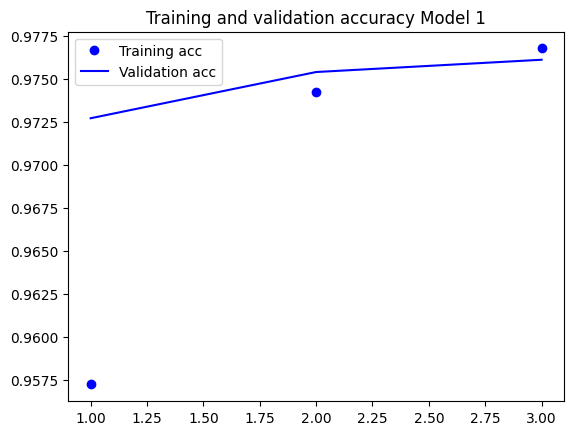

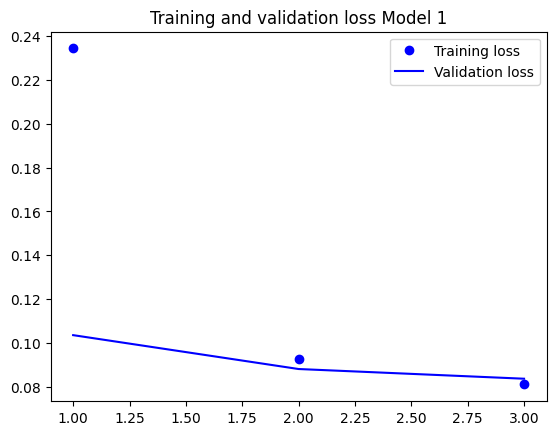

In [28]:
import matplotlib.pyplot as plt

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # to count from epoch 1 to the last epoch 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy Model 1')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss Model 1')
plt.legend()

plt.show()


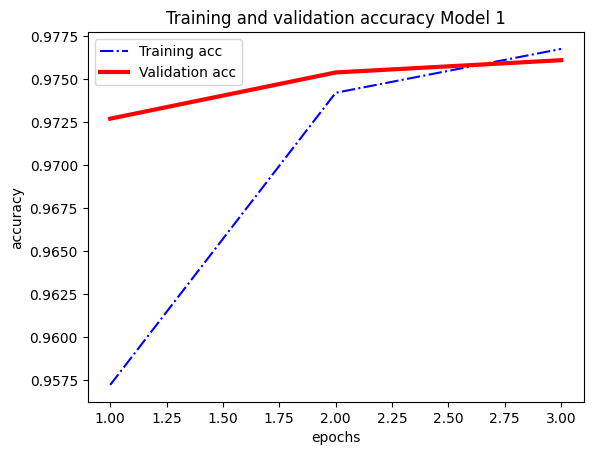

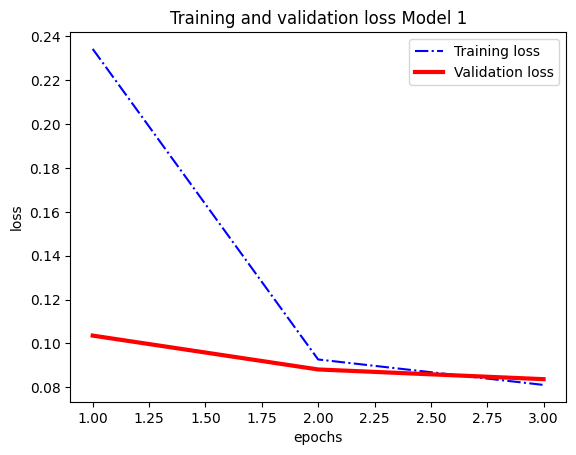

In [29]:
import matplotlib.pyplot as plt

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

epochs = range(1, len(loss) + 1)  # to count from epoch 1 to epoch 3

plt.plot(epochs, acc, 'b', linestyle = 'dashdot', label='Training acc')
plt.plot(epochs, val_acc, 'r', linewidth = '3', label='Validation acc')
plt.title('Training and validation accuracy Model 1')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', linestyle = 'dashdot', label='Training loss')
plt.plot(epochs, val_loss, 'r', linewidth = '3', label='Validation loss')
plt.title('Training and validation loss Model 1')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()


### Model_2

Layers: LSTM, Embedding, Dense

In [22]:
# Model_2 

model_2 = Sequential(name="Model_2")

model_2.add(Embedding(input_dim=num_words, output_dim=max_len,input_length=max_len))
model_2.add(LSTM(units=100,return_sequences=True))
model_2.add(Dense(num_tags, activation="softmax")) 

model_2.summary()

model_2.compile(optimizer = "rmsprop",           # with "rmsprop"
              loss = "categorical_crossentropy", # for 2 or more labels (multicl)
              metrics = ['accuracy'])

# Training Model_2

history_2 = model_2.fit(
    X_train, np.array(y_train),
    epochs = 3,
    batch_size = 32,              # 38846 / 32 = 1214
    validation_split = 0.1,       # train on 38846 samples (90% of 43163),              
    verbose = 1) # progress bar   # validate on 4317 samples


Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            1758900   
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 dense_2 (Dense)             (None, 50, 17)            1717      
                                                                 
Total params: 1,821,017
Trainable params: 1,821,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1214/1214 [==============================] - 19s 14ms/step - loss: 0.2339 - accuracy: 0.9462 - val_loss: 0.1270 - val_accuracy: 0.9645
Epoch 2/3
1214/1214 [==============================] - 8s 7ms/step - loss: 0.0959 - accuracy: 0.9744 - val_loss: 0.0763 - val_accuracy: 0.9788
Epoch 3/3
1214/1214 [====

In [23]:
# Evaluating Model_2

model_2.evaluate(X_test, np.array(y_test))   # 4796 / 32 = 150


150/150 [==============================] - 1s 3ms/step - loss: 0.0655 - accuracy: 0.9810


[0.06547199189662933, 0.9809591174125671]

## **Prediction**

In [22]:
# Tags enumerated

tag_idx


{'B-eve': 0,
 'I-gpe': 1,
 'B-geo': 2,
 'I-tim': 3,
 'O': 4,
 'I-art': 5,
 'I-per': 6,
 'I-eve': 7,
 'B-org': 8,
 'B-art': 9,
 'I-nat': 10,
 'I-geo': 11,
 'B-nat': 12,
 'B-per': 13,
 'B-gpe': 14,
 'I-org': 15,
 'B-tim': 16}

In [30]:
# Prediction - model_1 

pred = model_1.predict(np.array(X_test)) 

print(pred[1][0]) # second element of the first row (probabilities)
pred.shape  # (4796, 50, 17)

150/150 [==============================] - 1s 1ms/step
[1.9089055e-05 1.3025750e-05 7.6600850e-01 1.3658693e-09 6.0317543e-05
 1.0452848e-05 4.1641297e-06 5.7286388e-06 1.9335984e-01 3.7445086e-05
 8.9237113e-07 1.2552735e-03 3.1562295e-06 6.0008693e-04 3.6948264e-02
 1.6736357e-03 2.1407675e-07]


(4796, 50, 17)

In [35]:
# Prediction - model_1 
# Prediction in sentences did not work well

i = 0   # examples 3, 15
p = model_1.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("WORD", "PREDICTION"))
for w, pre in zip(X_test[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pre]))
    

1/1 [==============================] - 0s 20ms/step
WORD           : PREDICTION
Fernandes      : B-geo
democracy-building: I-org
weed           : I-org
ABDALLAHI      : B-per
obstacle       : I-per
saving         : O
video-teleconference: O
services       : O
lags           : O
spokesman      : O
service-oriented: O
Tut            : O
reshuffle      : O
ovarian        : O
subsidized     : O
Pang           : O
Bellerive      : B-geo
country        : O
two-week-long  : O
madrassas      : O
anticipate     : O
confessed      : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD       

### Some interesting things about this data

Precision, Recall, F1 and amount of data points

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import classification_report

class MemoryTagger(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y): # Expects a list of words as X and a list of tags as y
        self.memory = {}
        for word, tag in zip(X, y):
            if word not in self.memory:
                self.memory[word] = {}
            self.memory[word][tag] = self.memory[word].get(tag, 0) + 1
        self.memory = {word: max(tags, key=tags.get) for word, tags in self.memory.items()}
    
    def predict(self, X, y=None): # Predict the the tag from memory
                                  # If word is unknown, predict 'O'
        return [self.memory.get(word, 'O') for word in X]

words = data["Word"].tolist()
tags = data["Tag"].tolist()

pred = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)
       # 5-fold cross-validation for training and predicting

print(classification_report(y_true=tags, y_pred=pred))
       # classification report based on true tags and predicted tags
    

              precision    recall  f1-score   support

       B-art       0.20      0.05      0.09       402
       B-eve       0.54      0.25      0.34       308
       B-geo       0.78      0.85      0.81     37644
       B-gpe       0.94      0.93      0.94     15870
       B-nat       0.42      0.28      0.33       201
       B-org       0.67      0.49      0.56     20143
       B-per       0.78      0.65      0.71     16990
       B-tim       0.87      0.77      0.82     20333
       I-art       0.04      0.01      0.01       297
       I-eve       0.39      0.12      0.18       253
       I-geo       0.73      0.58      0.65      7414
       I-gpe       0.62      0.45      0.52       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.69      0.53      0.60     16784
       I-per       0.73      0.65      0.69     17251
       I-tim       0.58      0.13      0.21      6528
           O       0.97      0.99      0.98    887908

    accuracy              

# Now let's try a third model!

Keras API docs: https://keras.io/api/

For all layers with Keras:
https://keras.io/api/layers/

For all Activations:
https://keras.io/api/layers/activations/

For all Optimizers:
https://keras.io/api/optimizers/

Recommended: Chollet (Chapter 11 - Deep learning for text)


### Model_3

Layers: Embedding, SpatialDropout1D, Bidirectional LSTM, Dense

In [37]:
# Model_3

model_3 = Sequential(name="Model_3")

model_3.add(Embedding(input_dim=num_words, output_dim=max_len,input_length=max_len)) 
model_3.add(SpatialDropout1D(0.1)) 
model_3.add(Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1)))
model_3.add(Dense(num_tags, activation="softmax"))  
                                      
model_3.summary()

model_3.compile(optimizer = "adam",   ## another optimizer
              loss = "categorical_crossentropy", 
              metrics = ['accuracy'])


Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 50, 17)            3417      
                                                                 
Total params: 1,883,117
Trainable params: 1,883,117
Non-trainable params: 0
_________________________________________________________________


In [38]:
history_3 = model_3.fit(
    X_train, np.array(y_train),
    epochs = 3,
    batch_size = 512,      # another number for batch size
    validation_split = 0.1,
    verbose = 1)


Epoch 1/3
76/76 [==============================] - 16s 166ms/step - loss: 0.7021 - accuracy: 0.9230 - val_loss: 0.3352 - val_accuracy: 0.9336
Epoch 2/3
76/76 [==============================] - 13s 165ms/step - loss: 0.3049 - accuracy: 0.9331 - val_loss: 0.2656 - val_accuracy: 0.9336
Epoch 3/3
76/76 [==============================] - 13s 166ms/step - loss: 0.2172 - accuracy: 0.9376 - val_loss: 0.1778 - val_accuracy: 0.9487


In [39]:
model_3.evaluate(X_test, np.array(y_test))


150/150 [==============================] - 2s 12ms/step - loss: 0.1800 - accuracy: 0.9474


[0.17998704314231873, 0.9474061727523804]

### What is next?

•	Create your own way to pre-process the dataset below, organized by one sentence per line [Kaggle](https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus)

•	Try other model settings. 